# start

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
import torch
from transformers import Trainer
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader
from tqdm import tqdm  # for progress bars
import os
from transformers import BertConfig
from torch.nn.utils.rnn import pad_sequence

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount= True)
# dir = '/content/drive/MyDrive/trans/Annotation/Compare/'

In [ ]:
dir = '/content/data/'

# preprocessing

In [ ]:
names = os.listdir(dir)

In [ ]:
dataframes_train = [pd.read_csv(dir+file)[['Speaker', 'Utterance', 'DA_final']] for file in names[:8]]
dataframes_val = [pd.read_csv(dir+names[8])]
dataframes_test = [pd.read_csv(dir+names[9])]

In [ ]:
def categorize_label(label):
    if 'Extra Domain' in label:
        return 'Extra Domain'
    elif 'Question' in label:
        return 'Questions'
    elif 'Feedback' in label:
        return 'Feedback'
    elif label == 'Explanation':
        return 'Explanation'
    else:
        return 'Other'

In [ ]:
text_train = [list(df['Speaker']+ ': ' +df['Utterance']) for df in dataframes_train]
label_train = [list(df['DA_final'].fillna('NA').apply(categorize_label)) for df in dataframes_train]

In [ ]:
text_val = [list(df['Speaker']+ ': ' +df['Utterance']) for df in dataframes_val]
label_val = [list(df['DA_final'].fillna('NA').apply(categorize_label)) for df in dataframes_val]

In [ ]:
text_test = [list(df['Speaker']+ ': ' +df['Utterance']) for df in dataframes_test]
label_test = [list(df['DA_final'].fillna('NA').apply(categorize_label)) for df in dataframes_test]

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

custom_tokens = ['[DIALOGUE_START]', '[DIALOGUE_END]', '[START]', '[MID]', '[END]']

tokenizer.add_tokens(custom_tokens)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


5

In [ ]:
config = BertConfig.from_pretrained('bert-base-uncased')

config.hidden_dropout_prob = 0.4
config.attention_probs_dropout_prob = 0.4
config.num_labels = 5

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)
model.resize_token_embeddings(len(tokenizer))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(30527, 768)

In [ ]:
# def pad_nested_sequences(texts):
#     max_sentence_length = 0
#     max_sentences_per_text = 0

#     # Calculate max length for tokens and sentences
#     for text in texts:
#         max_sentences_per_text = max(max_sentences_per_text, len(text))
#         for sentence in text:
#             max_sentence_length = max(max_sentence_length, len(sentence))

#     # Pad each sentence to the max length of tokens
#     padded_texts = []
#     for text in texts:
#         padded_sentences = []
#         for sentence in text:
#             padded_sentence = torch.tensor(sentence, dtype=torch.long)
#             # Pad each sentence to the same length
#             if len(sentence) < max_sentence_length:
#                 padded_sentence = torch.cat([padded_sentence, torch.zeros(max_sentence_length - len(sentence), dtype=torch.long)])
#             padded_sentences.append(padded_sentence)
#         # Ensure all texts have the same number of sentences
#         if len(padded_sentences) < max_sentences_per_text:
#             extra_padding = [torch.zeros(max_sentence_length, dtype=torch.long) for _ in range(max_sentences_per_text - len(padded_sentences))]
#             padded_sentences.extend(extra_padding)
#         padded_texts.append(torch.stack(padded_sentences))

#     # Stack all texts
#     padded_texts = torch.stack(padded_texts)

#     return padded_texts

In [ ]:
def pad_text(text):
  max_len = max(len(seq) for sentence in text for seq in sentence)

  # Convert lists to tensors and pad each sequence to the maximum length
  padded_text = []
  for sentence in text:
      # Convert each sequence in the sentence to a tensor
      tensors = [torch.tensor(seq) for seq in sentence]
      # Pad the sequences in this sentence to the maximum length found
      padded_sentence = pad_sequence(tensors, batch_first=True, padding_value=0)
      # Ensure all sequences are padded to the max length
      if padded_sentence.size(1) < max_len:
          padded_sentence = torch.cat([padded_sentence, torch.zeros(padded_sentence.size(0), max_len - padded_sentence.size(1), dtype=torch.long)], dim=1)
      padded_text.append(padded_sentence)
  final_tensor = torch.cat(padded_text, dim=0)

  return (final_tensor)

In [ ]:
def preprocess_dialogues(dialogues):
    processed_dialogues = []
    for dialogue in dialogues:
        processed_sentences = []
        for i, sentence in enumerate(dialogue):
            if i == 0:
                # Start of dialogue
                tokens = '[CLS] [DIALOGUE_START] [START] ' + sentence + ' [SEP]'
            elif i == len(dialogue) - 1:
                # End of dialogue
                tokens = '[CLS] [END] ' + sentence + ' [DIALOGUE_END] [SEP]'
            else:
                # Middle of dialogue
                tokens = '[CLS] [MID] ' + sentence + ' [SEP]'
            # Encode the tokens using the tokenizer
            encoded_tokens = tokenizer.encode(tokens, add_special_tokens=False)
            processed_sentences.append(encoded_tokens)
        processed_dialogues.append(processed_sentences)
    return  pad_text(processed_dialogues)

In [ ]:
processed_dialogues_train = preprocess_dialogues(text_train)
processed_dialogues_val = preprocess_dialogues(text_val)
processed_dialogues_test = preprocess_dialogues(text_test)

In [ ]:
def pad_label(nested_list):
  final_list = [item for sublist in nested_list for item in sublist]
  return(final_list)


In [ ]:
label_dict = {l: idx for idx, l in enumerate(['Extra Domain', 'Questions', 'Feedback', 'Explanation', 'Other'])}
label_train = pad_label([[label_dict[item] for item in sublist] for sublist in label_train])
label_val = pad_label([[label_dict[item] for item in sublist] for sublist in label_val])
label_test = pad_label([[label_dict[item] for item in sublist] for sublist in label_test])

In [ ]:
attention_mask_train = [[int(item != 0) for item in seq] for seq in processed_dialogues_train]
attention_mask_val = [[int(item != 0) for item in seq] for seq in processed_dialogues_val]
attention_mask_test = [[int(item != 0) for item in seq] for seq in processed_dialogues_test]

In [ ]:
train_data = {
    'input_ids': processed_dialogues_train,
    'attention_mask': attention_mask_train
}
val_data = {
    'input_ids': processed_dialogues_val,
    'attention_mask': attention_mask_val
}
test_data = {
    'input_ids': processed_dialogues_test,
    'attention_mask': attention_mask_test
}

# data

In [ ]:
class SentenceDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = SentenceDataset(train_data, label_train)
val_dataset = SentenceDataset(val_data, label_val)
test_dataset = SentenceDataset(test_data, label_test)

# train

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [ ]:
num_epochs = 9
optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = num_epochs, eta_min=1e-6)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
for batch in train_loader:
  print(batch['input_ids'].shape)
  print(batch['attention_mask'].shape)
  print(batch['labels'].shape)
  break

torch.Size([16, 67])
torch.Size([16, 67])
torch.Size([16])


<ipython-input-20-1d262058fdfb>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [ ]:
def train(model, optimizer, train_loader):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc="Training"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)
        labels = batch['labels'].to(model.device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
    average_loss = total_loss / len(train_loader)
    print(f"Training loss: {average_loss}, LR: {optimizer.param_groups[0]['lr']}")

def evaluate(model, val_loader):
    model.eval()
    total_loss = 0
    total_correct = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(model.device)
            attention_mask = batch['attention_mask'].to(model.device)
            labels = batch['labels'].to(model.device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            predictions = outputs.logits.argmax(dim=-1)
            total_correct += (predictions == labels).sum().item()

    average_loss = total_loss / len(val_loader)
    accuracy = total_correct / len(val_loader.dataset)
    print(f"Evaluation loss: {average_loss}, Accuracy: {accuracy}")

In [ ]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train(model, optimizer, train_loader)
    evaluate(model, val_loader)

Epoch 1/9


Training:   0%|          | 0/308 [00:00<?, ?it/s]<ipython-input-20-1d262058fdfb>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Training: 100%|██████████| 308/308 [14:41<00:00,  2.86s/it]


Training loss: 1.0822468900254794, LR: 4.426808885641685e-05


Evaluating: 100%|██████████| 47/47 [00:36<00:00,  1.29it/s]


Evaluation loss: 1.5696663739199335, Accuracy: 0.42780026990553305
Epoch 2/9


Training: 100%|██████████| 308/308 [14:38<00:00,  2.85s/it]


Training loss: 0.8320906190806395, LR: 2.9754380352842822e-05


Evaluating: 100%|██████████| 47/47 [00:35<00:00,  1.32it/s]


Evaluation loss: 1.3549617738165753, Accuracy: 0.4426450742240216
Epoch 3/9


Training: 100%|██████████| 308/308 [14:29<00:00,  2.82s/it]


Training loss: 0.7691463710522497, LR: 1.32500000000013e-05


Evaluating: 100%|██████████| 47/47 [00:36<00:00,  1.30it/s]


Evaluation loss: 1.2139081972393584, Accuracy: 0.5114709851551957
Epoch 4/9


Training: 100%|██████████| 308/308 [14:32<00:00,  2.83s/it]


Training loss: 0.7022136800087891, LR: 2.477530790745521e-06


Evaluating: 100%|██████████| 47/47 [00:36<00:00,  1.29it/s]


Evaluation loss: 1.1958785798955471, Accuracy: 0.5519568151147098
Epoch 5/9


Training: 100%|██████████| 308/308 [14:31<00:00,  2.83s/it]


Training loss: 0.6580220266402542, LR: 2.477530790745244e-06


Evaluating: 100%|██████████| 47/47 [00:35<00:00,  1.32it/s]


Evaluation loss: 1.1822895025636286, Accuracy: 0.5452091767881242
Epoch 6/9


Training: 100%|██████████| 308/308 [14:25<00:00,  2.81s/it]


Training loss: 0.6356625451960347, LR: 1.325000000000761e-05


Evaluating: 100%|██████████| 47/47 [00:35<00:00,  1.32it/s]


Evaluation loss: 1.3506692765240973, Accuracy: 0.5452091767881242
Epoch 7/9


Training: 100%|██████████| 308/308 [14:25<00:00,  2.81s/it]


Training loss: 0.6021524364878605, LR: 2.9754380352842683e-05


Evaluating: 100%|██████████| 47/47 [00:35<00:00,  1.31it/s]


Evaluation loss: 1.1751150233631438, Accuracy: 0.5775978407557355
Epoch 8/9


Training: 100%|██████████| 308/308 [14:23<00:00,  2.80s/it]


Training loss: 0.5913686625562705, LR: 4.4268088856427896e-05


Evaluating: 100%|██████████| 47/47 [00:35<00:00,  1.32it/s]


Evaluation loss: 1.3240033985769495, Accuracy: 0.5465587044534413
Epoch 9/9


Training: 100%|██████████| 308/308 [14:29<00:00,  2.82s/it]


Training loss: 0.5584854167680462, LR: 5.0000000000021395e-05


Evaluating: 100%|██████████| 47/47 [00:35<00:00,  1.33it/s]

Evaluation loss: 1.2632371844287882, Accuracy: 0.5883940620782726


# test

In [ ]:
evaluate(model, test_loader)

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]<ipython-input-20-1d262058fdfb>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Evaluating: 100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

Evaluation loss: 0.9009352711960673, Accuracy: 0.7203125


In [ ]:
def prepare_data(sentences):
    encodings = tokenizer(sentences, padding=True, truncation=True, max_length=128, return_tensors="pt")
    return encodings
def predict(model, sentences):
    model.eval()  # set the model to evaluation mode
    with torch.no_grad():  # disable gradient computation for inference
        inputs = prepare_data(sentences)
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=-1)
    return predictions

In [ ]:
d = pd.read_csv('/content/427c9340-1ea0-4e3c-851d-49d0049bbaf1.csv')
new_sentences = list(d['Speaker']+ ': ' +d['Utterance'])

In [ ]:
predicted_labels = predict(model, new_sentences)

# Convert numeric predictions back to labels if necessary
label_names = {value: key for key, value in label_dict.items()}  # Assuming label_dict from training
predicted_label_names = [label_names[label.item()] for label in predicted_labels]
print(predicted_label_names)

['Extra Domain', 'Other', 'Other', 'Extra Domain', 'Extra Domain', 'Other', 'Other', 'Other', 'Other', 'Other', 'Explanation', 'Other', 'Explanation', 'Explanation', 'Explanation', 'Questions', 'Other', 'Extra Domain', 'Explanation', 'Other', 'Other', 'Other', 'Explanation', 'Explanation', 'Other', 'Explanation', 'Other', 'Explanation', 'Explanation', 'Explanation', 'Questions', 'Questions', 'Other', 'Other', 'Explanation', 'Other', 'Explanation', 'Other', 'Explanation', 'Explanation', 'Other', 'Explanation', 'Explanation', 'Explanation', 'Explanation', 'Explanation', 'Explanation', 'Explanation', 'Questions', 'Other', 'Explanation', 'Explanation', 'Other', 'Other', 'Explanation', 'Feedback', 'Questions', 'Explanation', 'Other', 'Explanation', 'Other', 'Explanation', 'Explanation', 'Other', 'Explanation', 'Other', 'Explanation', 'Other', 'Explanation', 'Other', 'Explanation', 'Explanation', 'Other', 'Explanation', 'Questions', 'Explanation', 'Explanation', 'Questions', 'Other', 'Other'

In [ ]:
d['DA'] = predicted_label_names
d

,Speaker,Utterance start time (milliseconds),Utterance end time (milliseconds),Utterance,Sentiment,DA
0,student,5280,6118,I had to go to.,NEUTRAL,Extra Domain
1,student,6214,6850,So.,NEUTRAL,Other
2,tutor,7830,8730,I see.,NEUTRAL,Other
3,tutor,9360,11330,"Um, just give me a minute.",NEUTRAL,Extra Domain
4,tutor,17150,21810,"I'll just upload the, um, sheet that we are su...",NEUTRAL,Extra Domain
...,...,...,...,...,...,...
834,tutor,3605652,3606084,Okay?,NEUTRAL,Other
835,tutor,3606132,3609052,"Okay, that should be good.",POSITIVE,Feedback
836,tutor,3609236,3612612,"Until then, you have a very good rest of your ...",POSITIVE,Other
837,student,3612756,3613604,You too.,NEUTRAL,Other


Text(0, 0.5, 'DA')

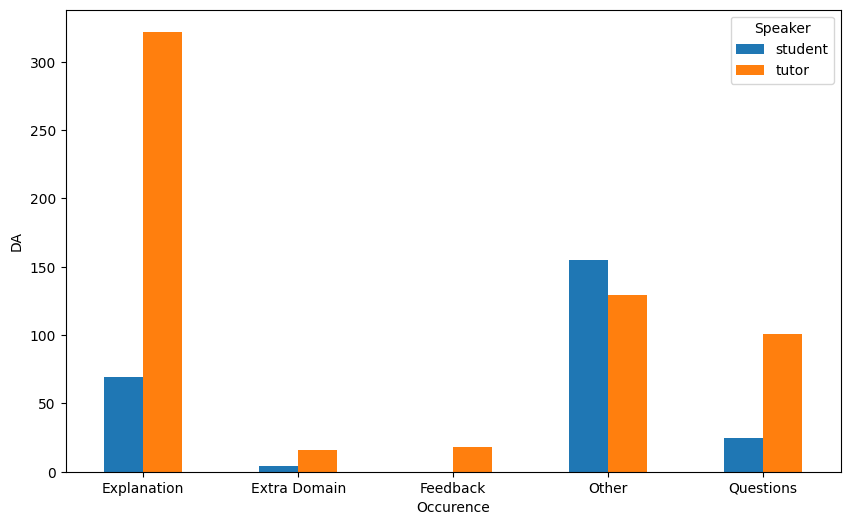

In [ ]:
  from collections import Counter
  import matplotlib.pyplot as plt
  s_da = d[d['Speaker'] == 'student']['DA']
  t_da = d[d['Speaker'] == 'tutor']['DA']

  s_ct = pd.Series(Counter(s_da))
  s_ct = s_ct.sort_index()
  t_ct = pd.Series(Counter(t_da))
  t_ct = t_ct.sort_index()

  categories = ['Explanation', 'Extra Domain', 'Feedback', 'Other', 'Questions']

  label_counts_transposed = d.groupby(['DA', 'Speaker']).size().unstack(fill_value=0)

  # Plotting with labels on x-axis and different colors for each speaker
  label_counts_transposed.plot(kind='bar', figsize=(10, 6), color=['#1f77b4', '#ff7f0e'])
  plt.xticks(rotation=0)
  plt.legend(title='Speaker')

  plt.xlabel("Occurence")
  plt.ylabel("DA")

In [ ]:
torch.save(
      {"model_state_dict"         : model.state_dict(),
        "optimizer_state_dict"     : optimizer.state_dict(),
        "scheduler_state_dict"     : scheduler.state_dict() if scheduler is not None else {},
        "epoch"                    : epoch},
      '5_bert_model.pth'
)